In [1]:
%load_ext lab_black
import numpy as np
import uproot as up
from matplotlib import pyplot as plt
from ipynb.fs.defs.covfit import *
from scipy.stats import chi2

In [2]:
# Load the data from https://arxiv.org/abs/1811.02774

files = {
    "Neut": "mnvCC0pi2D_neut540LFG.root",
    "Genie": "mnvCC0pi2D_genieG1810b.root",
}

modes = ["nu"]

data = {}
MC = {}
MC_scale = {}
var = {}
shape_var = {}
total_error = {}
cov = {}
cov_inv = {}
bin_widths = {}
data_integral = {}
MC_integral = {}
shape_total_cov = {}
shape_total_cov_inv = {}

for gen, filename in files.items():
    F = up.open(filename)

    for mode in modes:
        # Covariance and variance of data
        cov[mode] = F[f"MINERvA_CC0pi_XSec_2Dptpz_{mode}_COV"]
        cov[mode] = cov[mode].numpy()[0]  # * 1e-76
        var[mode] = np.diag(cov[mode])

        # Remove empty bins
        i_good = var[mode] > 0
        # Also remove "problematic" bins
        if False:
            i_good[:24] = False
            i_good[-24:] = False
            i_good[12::12] = False
            i_good[11::12] = False
            i_good[10::12] = False
            i_good[9::12] = False
            i_good[0::12] = False
            i_good[1::12] = False
            i_good[2::12] = False
            i_good[3::12] = False
        print(np.sum(i_good), len(i_good))
        var[mode] = var[mode][i_good]
        cov[mode] = cov[mode][i_good][:, i_good]

        # Get bin areas
        dump, [(xbins, ybins)] = F[f"MINERvA_CC0pi_XSec_2Dptpz_{mode}_data"].numpy()
        xbins = xbins[1:] - xbins[:-1]
        ybins = ybins[1:] - ybins[:-1]
        bin_widths[mode] = xbins[np.newaxis, :] * ybins[:, np.newaxis]
        bin_widths[mode] = bin_widths[mode].flatten()[i_good]
        # bin_widths[mode][:] = 1.0 # Ignore bin widths

        # Covariance inverse
        cov_inv[mode] = np.linalg.inv(cov[mode])

        # The data
        hist = F[f"MINERvA_CC0pi_XSec_2Dptpz_{mode}_data_1D"]
        data[mode] = hist.numpy()[0][i_good]
        data_integral[mode] = np.sum(data[mode] * bin_widths[mode])

        # Split shape and norm like in MiniBooNE
        # shape = data[mode] / data_integral[mode]
        jac = np.eye(len(data[mode])) / data_integral[mode] - (
            data[mode][:, np.newaxis]
            * bin_widths[mode][np.newaxis, :]
            / (data_integral[mode] ** 2)
        )
        jac = np.append(jac, [bin_widths[mode]], axis=0)
        Q = jac @ cov[mode] @ jac.T
        Q[:-1, :] *= data_integral[mode]  # Scale shape errors to data result
        Q[:, :-1] *= data_integral[mode]  # Scale shape errors to data result
        shape_var[mode] = np.diag(Q)[:-1]
        total_error[mode] = np.sqrt(Q[-1, -1])
        shape_total_cov[mode] = Q
        shape_total_cov_inv[mode] = np.linalg.pinv(Q)

        # Model predictions
        hist = F[f"MINERvA_CC0pi_XSec_2Dptpz_{mode}_MC_1D"]
        hist = hist.numpy()[0][i_good]
        MC[(mode, gen)] = hist
        MC_integral[(mode, gen)] = np.sum(MC[(mode, gen)] * bin_widths[mode])
        MC_scale[(mode, gen)] = data_integral[mode] / MC_integral[(mode, gen)]

        print(data_integral[mode], MC_integral[(mode, gen)])

144 156
4.635665394345005e-39 4.23725480052921e-39
144 156
4.635665394345005e-39 4.266186516256924e-39


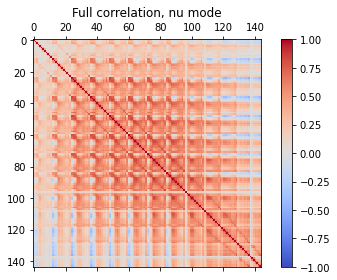

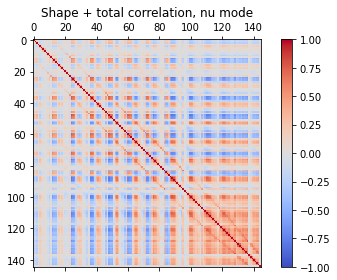

In [3]:
from matplotlib.colors import Normalize

for mode in modes:
    fig, ax = plt.subplots()
    cor = cov[mode] / (
        np.sqrt(var[mode])[np.newaxis, :] * np.sqrt(var[mode])[:, np.newaxis]
    )
    m = ax.matshow(cor, cmap="coolwarm", norm=Normalize(-1, 1))
    fig.colorbar(m)
    ax.set_title(f"Full correlation, {mode} mode")
    fig.tight_layout()

    fig, ax = plt.subplots()
    cor = shape_total_cov[mode] / (
        np.sqrt(np.diag(shape_total_cov[mode]))[np.newaxis, :]
        * np.sqrt(np.diag(shape_total_cov[mode]))[:, np.newaxis]
    )
    m = ax.matshow(cor, cmap="coolwarm", norm=Normalize(-1, 1))
    fig.colorbar(m)
    ax.set_title(f"Shape + total correlation, {mode} mode")
    fig.tight_layout()

In [4]:
# as-is p-values
p_fixed = {}
for mode in modes:
    for gen in files:
        p = {}
        # Full covariance p-value
        z = data[mode] - MC[(mode, gen)]
        p["full"] = chi2(df=len(z)).sf(z.T @ cov_inv[mode] @ z)
        # Diagonal only p-values
        z = np.sqrt((data[mode] - MC[(mode, gen)]) ** 2 / var[mode])
        p["naive"] = chi2(df=len(z)).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)
        p_fixed[(mode, gen)] = p

nu Neut
{'full': 2.7499989754603504e-20, 'naive': 2.2520676358548646e-08, 'fitted': 2.087380759019375e-06, 'invariant': 2.0725285290481484e-06}
nu Genie
{'full': 2.3000037680240234e-36, 'naive': 8.230474492164113e-39, 'fitted': 0.0, 'invariant': 6.94590693492013e-18}


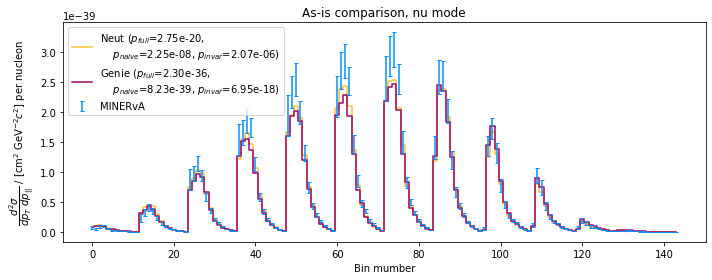

In [5]:
for mode in modes:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.errorbar(
        np.arange(len(data[mode])),
        data[mode],
        np.sqrt(var[mode]),
        linestyle="",
        label="MINERvA",
        zorder=5,
        capsize=2,
    )
    for gen in files:
        ax.step(
            np.arange(len(MC[(mode, gen)])),
            MC[(mode, gen)],
            where="mid",
            label=gen
            + f" ($p_{{full}}$={p_fixed[(mode,gen)]['full']:.2e},\n"
            + f"    $p_{{naive}}$={p_fixed[(mode,gen)]['naive']:.2e}, "
            + f"$p_{{invar}}$={p_fixed[(mode,gen)]['invariant']:.2e})",
        )
    # ax.set_yscale("log")
    # ax.set_ylim(top=ax.get_ylim()[1] * 1.2)
    ax.set_xlabel("Bin mumber")
    ax.set_ylabel(
        r"$\dfrac{d^2 \sigma}{dp_{T}\ dp_{||}}$ / [cm$^2$ GeV$^{-2} c^{2}$] per nucleon"
    )
    ax.legend(loc="upper left")
    ax.set_title(f"As-is comparison, {mode} mode")
    fig.tight_layout()
    fig.savefig(f"plots/minerva-{mode}.pdf")

In [6]:
# shape only p-values
p_shape = {}
for mode in modes:
    for gen in files:
        p = {}
        ## Full covariance p-value
        # z = data[mode] - MC[(mode, gen)]
        # p["full"] = chi2(df=len(z)).sf(z.T @ cov_inv[mode] @ z)
        # Diagonal only p-values
        z = np.sqrt(
            (data[mode] - MC_scale[(mode, gen)] * MC[(mode, gen)]) ** 2
            / shape_var[mode]
        )
        p["naive"] = chi2(df=len(z)).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)
        p_shape[(mode, gen)] = p

nu Neut
{'naive': 5.466780662838113e-23, 'fitted': 1.3597826753475317e-08, 'invariant': 1.3501061279313426e-08}
nu Genie
{'naive': 4.868076386743997e-72, 'fitted': 0.0, 'invariant': 6.892155721783719e-23}


In [7]:
# shape + norm only p-values
p_full = {}
for mode in modes:
    for gen in files:
        p = {}
        ## Full covariance p-value
        # z = data[mode] - MC[(mode, gen)]
        # p["full"] = chi2(df=len(z)).sf(z.T @ cov_inv[mode] @ z)
        # Diagonal only p-values
        z = np.sqrt(
            (data[mode] - MC_scale[(mode, gen)] * MC[(mode, gen)]) ** 2
            / shape_var[mode]
        )
        z = np.append(
            z,
            np.abs(data_integral[mode] - MC_integral[(mode, gen)]) / total_error[mode],
        )

        p["naive"] = chi2(df=len(z)).sf(naive(z))
        p["fitted"] = BEE2(df=len(z)).sf(fitted(z))
        p["invariant"] = chi2(df=1).sf(invariant3(z, alpha=2 / 3))
        print(f"{mode} {gen}")
        print(p)
        p_full[(mode, gen)] = p

nu Neut
{'naive': 6.376001014102646e-23, 'fitted': 1.3692256106700995e-08, 'invariant': 1.3594140528500835e-08}
nu Genie
{'naive': 7.41434204825412e-72, 'fitted': 0.0, 'invariant': 6.939671740457666e-23}


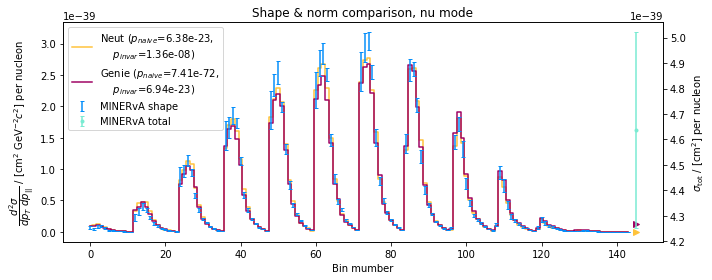

In [8]:
for mode in modes:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax2 = ax.twinx()
    ax.errorbar(
        np.arange(len(data[mode])),
        data[mode],
        np.sqrt(shape_var[mode]),
        linestyle="",
        label="MINERvA shape",
        zorder=4,
        capsize=2,
    )
    tot = ax2.errorbar(
        [len(data[mode]) + 1],
        [data_integral[mode]],
        [total_error[mode]],
        linestyle="",
        marker=".",
        color="C5",
        label="MINERvA total",
        zorder=4,
        capsize=2,
    )
    for gen in files:
        y = MC_scale[(mode, gen)] * MC[(mode, gen)]
        art = ax.step(
            np.arange(len(y)),
            y,
            where="mid",
            label=gen
            + f" ($p_{{naive}}$={p_full[(mode,gen)]['naive']:.2e},\n"
            + f"    $p_{{invar}}$={p_full[(mode,gen)]['invariant']:.2e})",
        )
        ax2.plot(
            len(y) + 1,
            MC_integral[mode, gen],
            marker=">",
            linewidth=2,
            color=art[0].get_color(),
        )
    # ax.set_yscale("log")
    # ax.set_ylim(top=ax.get_ylim()[1] * 1.2)
    ax.set_xlabel("Bin mumber")
    ax.set_ylabel(
        r"$\dfrac{d^2 \sigma}{dp_{T}\ dp_{||}}$ / [cm$^2$ GeV$^{-2} c^{2}$] per nucleon"
    )
    ax2.set_ylabel(r"$\sigma_{\mathrm{tot}}$ / [cm$^2$] per nucleon")
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles + handles2, labels + labels2, loc="upper left")
    ax.set_title(f"Shape & norm comparison, {mode} mode")
    fig.tight_layout()
    fig.savefig(f"plots/minerva-{mode}-shape.pdf")

In [9]:
%%time
# Test with toy data
N = 100000
rng = np.random.default_rng()
distances = {}
for mode in modes:
    toys = rng.multivariate_normal(
        mean=np.zeros_like(data[mode]), cov=cov[mode], size=N
    )
    z = toys / np.sqrt(var[mode])
    distances[mode] = {
        r"invariant 3": (invariant3(z, alpha=2 / 3, fast=True), chi2(df=1),),
        "naive": (naive(z), chi2(df=len(var[mode]))),
        "full": (
            (toys[:, np.newaxis, :] @ cov_inv[mode] @ toys[:, :, np.newaxis]).flatten(),
            chi2(df=len(var[mode])),
        ),
    }
    del z
    del toys

CPU times: user 15.2 s, sys: 8.33 s, total: 23.5 s
Wall time: 15.4 s


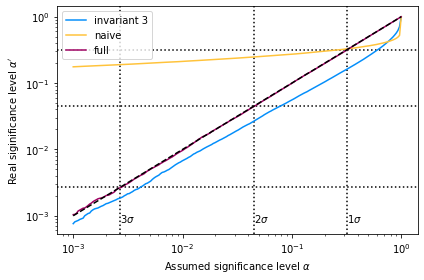

In [10]:
# siginifcance levels
for mode in modes:
    fig, ax = plt.subplots()
    for s in [1, 2, 3]:
        SL = chi2.sf(s ** 2, df=1)
        ax.axhline(SL, color="k", linestyle="dotted")
        ax.axvline(SL, color="k", linestyle="dotted")
        ax.annotate(f"${s}\sigma $ ", (SL, 0.05), xycoords=("data", "axes fraction"))

    x = np.logspace(-3, 0, 200)
    for name, (toys, expected) in distances[mode].items():
        y = np.sum(toys[:, np.newaxis] >= expected.isf(x), axis=0) / len(toys)
        ax.plot(x, y, label=name)
    ax.plot([x[0], 1], [x[0], 1], color="k", linestyle="dashed")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"Real siginificance level $\alpha'$")
    ax.set_xlabel(r"Assumed significance level $\alpha$")
    ax.legend(loc="upper left")
    fig.tight_layout()
    fig.savefig(f"plots/minerva-{mode}-significance.pdf")

In [11]:
del distances

In [12]:
%%time
# Test with shape + norm toy data
rng = np.random.default_rng()
distances = {}
for mode in modes:
    toys = rng.multivariate_normal(
        mean=np.zeros(shape_total_cov[mode].shape[0]), cov=shape_total_cov[mode], size=N
    )
    z = toys / np.sqrt(np.diag(shape_total_cov[mode]))
    distances[mode] = {
        r"invariant 3": (invariant3(z, alpha=2 / 3, fast=True), chi2(df=1),),
        "naive": (naive(z), chi2(df=z.shape[-1])),
        "full": (
            (toys[:, np.newaxis, :] @ shape_total_cov_inv[mode] @ toys[:, :, np.newaxis]).flatten(),
            chi2(df=len(var[mode])),
        ),
    }
    del z
    del toys

CPU times: user 15.5 s, sys: 8.69 s, total: 24.2 s
Wall time: 15.6 s


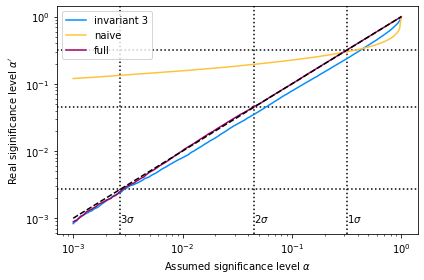

In [13]:
# siginifcance levels
for mode in modes:
    fig, ax = plt.subplots()
    for s in [1, 2, 3]:
        SL = chi2.sf(s ** 2, df=1)
        ax.axhline(SL, color="k", linestyle="dotted")
        ax.axvline(SL, color="k", linestyle="dotted")
        ax.annotate(f"${s}\sigma $ ", (SL, 0.05), xycoords=("data", "axes fraction"))

    x = np.logspace(-3, 0, 200)
    for name, (toys, expected) in distances[mode].items():
        y = np.sum(toys[:, np.newaxis] >= expected.isf(x), axis=0) / len(toys)
        ax.plot(x, y, label=name)
    ax.plot([x[0], 1], [x[0], 1], color="k", linestyle="dashed")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"Real siginificance level $\alpha'$")
    ax.set_xlabel(r"Assumed significance level $\alpha$")
    ax.legend(loc="upper left")
    fig.tight_layout()
    fig.savefig(f"plots/minerva-{mode}-decomposed-significance.pdf")

In [14]:
del distances